# Dependency, Library and Setting

In [1]:
!pip install tensorflow_text # for tensorflow_text
!pip install pythainlp # to tokenize Thai text
!pip install translators --upgrade # for translating Thai to English
!pip install tableone # to create data characteristics

ERROR: Invalid requirement: '#'
ERROR: Invalid requirement: '#'
ERROR: Invalid requirement: '#'
ERROR: Invalid requirement: '#'


In [2]:
# to make sure that our work can be reproducible, we need to set seed
import numpy as np
import os
import random
import tensorflow as tf
from google.colab import data_table
data_table.enable_dataframe_formatter()
print(f'tensorflow version = {tf.__version__}')

def set_seed(seed):
    os.environ["TF_DETERMINISTIC_OPS"] = "1"
    os.environ['PYTHONHASHSEED']= str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    print(f"random seed is set as {seed}")

set_seed(2022)

ModuleNotFoundError: No module named 'tensorflow'

# Data retrieval <br>
In this workshop, we use colon cancer data from the Department of Medicine, Ramathibodi Hospital. The data is only available to be accessed in the workshop on 25th December 2022. <br>
The download link --> https://drive.google.com/file/d/10a8Uu23bZXI85EzQtcdSlZoh6swYeC1a/view


In [3]:
import pandas as pd
# URL for downloading the dataset
URL = "https://drive.google.com/file/d/10a8Uu23bZXI85EzQtcdSlZoh6swYeC1a/view"
  # using file ID to download the dataset
downloaded_URL = 'https://drive.google.com/uc?id=' + URL.split('/')[-2]
print(f'The URL format that we need for downloading from Gdrive --> {downloaded_URL}')
print('\n')

# download the dataset
df = pd.read_csv(downloaded_URL, dtype = {'label' : int, 'age' : int, 'gender': int})

df.sample(3, random_state = 1234)

The URL format that we need for downloading from Gdrive --> https://drive.google.com/uc?id=10a8Uu23bZXI85EzQtcdSlZoh6swYeC1a




,hn,an,age,gender,pdx,brief_raw,course_raw,label
164,wpXCk2hnwqrCm8Kc,wpLCmGtuwrLCosKf,73,1,I251,Known case : double vessel disease s/p PCI ('5...,"# NSTEMI with monomorphic VT at 7 MW , no ches...",0
200,wpXCmGxmwqnCncKi,wpLCmmpmwq3CnMKf,71,2,I500,"U/D - CKD stage5 - DM type2, HT, DLP - 2เดือ...",# CHF + volume overload - จาก clinical + ecg ค...,0
73,wpPClWRrwrHCn8Ke,wpLCmmxmwq3Cn8Kd,66,1,C20,CC: นัดมาให้ยาเคมีบำบัด PI: known case locally...,#CA lower rectum with lung metastasis -S/P FO...,1


# Data exploration
Generally, we want to know about the basic characteristics of the data, for instance, the number of patients, age, gender, and disease outcomes. However, additional information must be explored for the NLP task, including the number of documents, number of words, vocabulary size, word length per document, etc.
So we will explore all this information and describe them with statistics.


In [5]:
## prepare data for descriptive analysis
# combined text data from two features
df['text'] = df['brief_raw'] + ' ' + df['course_raw']
# lower case
df['text_prep'] = df['text'].astype(str).str.lower()
# repalce new line with white space
df['text_prep'] = df['text_prep'].str.replace(r'\n', ' ').str.replace(r'\r', ' ')
# replace multiple white spaces with a single white space
df['text_prep'] = df['text_prep'].str.replace(r'^\s+|\s+$', '').str.replace(r'\s+', ' ')

df[['hn','age','gender','pdx','label','text','text_prep']].sample(3, random_state = 1234)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: The default value of regex will change from True to False in a future version.
  if __name__ == '__main__':


,hn,age,gender,pdx,label,text,text_prep
164,wpXCk2hnwqrCm8Kc,73,1,I251,0,Known case : double vessel disease s/p PCI ('5...,known case : double vessel disease s/p pci ('5...
200,wpXCmGxmwqnCncKi,71,2,I500,0,"U/D - CKD stage5 - DM type2, HT, DLP - 2เดือ...","u/d - ckd stage5 - dm type2, ht, dlp - 2เดือน ..."
73,wpPClWRrwrHCn8Ke,66,1,C20,1,CC: นัดมาให้ยาเคมีบำบัด PI: known case locally...,cc: นัดมาให้ยาเคมีบำบัด pi: known case locally...


In [ ]:
import string
from pythainlp import word_tokenize
import re
## prepare data for descriptive analysis
  # word tokenization --> use Thai tokenizer from pythainlp as our text are mixed Thai-English
  # engine="newmm" -> dictionary-based with Maximum Matching 
df['token'] = df['text_prep'].apply(lambda x: word_tokenize(x, engine="newmm"))
  # excluded characters
exc = ['\x84', ' '] + [*string.punctuation]
df['token'] = df['token'].apply(lambda x : [ele for ele in x if ele not in exc])
  # count number of tokens
df['len'] = df['token'].apply(len)

# Thai only tokens
pattern_thai = r"[ก-๙]+"
th = re.compile(pattern_thai)
df['vocab_th'] = df['token'].apply(lambda x : list(filter(th.match, x)))
df['len_th'] = df['vocab_th'].apply(len)

# English only tokens
pattern_en = r"^[a-zA-Z0-9?><;,{}[\]\-_+=!@#$%\^&*|']*$"
en = re.compile(pattern_en)
df['vocab_en'] = df['token'].apply(lambda x : list(filter(en.match, x)))
df['len_en'] = df['vocab_en'].apply(len)

# data for descriptive
data = df.copy()
data['gender'] = df['gender'].replace({1: 'male', 2: 'female'})
data['label'] = df['label'].replace({1: 'Yes', 0 : 'No'})

In [ ]:
data[['hn','len','token']].sample(3, random_state = 1234)

,hn,len,token
164,wpXCk2hnwqrCm8Kc,345,"[known, case, double, vessel, disease, s, p, p..."
200,wpXCmGxmwqnCncKi,161,"[u, d, ckd, stage, 5, dm, type, 2, ht, dlp, 2,..."
73,wpPClWRrwrHCn8Ke,366,"[cc, นัด, มา, ให้ยา, เคมี, บำบัด, pi, known, c..."


In [ ]:
data[['hn','len_th','vocab_th']].sample(3, random_state = 1234)

,hn,len_th,vocab_th
164,wpXCk2hnwqrCm8Kc,79,"[มา, ด้วย, จุก, แน่น, ลิ้นปี่, ล่าสุด, มี, อาก..."
200,wpXCmGxmwqnCncKi,93,"[เดือน, มี, อาการ, เหนื่อย, นอน, ราบ, ไม่, ได้..."
73,wpPClWRrwrHCn8Ke,77,"[นัด, มา, ให้ยา, เคมี, บำบัด, ปี, ครบ, พ.ค., ก..."


In [ ]:
data[['hn','len_en','vocab_en']].sample(3, random_state = 1234)

,hn,len_en,vocab_en
164,wpXCk2hnwqrCm8Kc,262,"[known, case, double, vessel, disease, s, p, p..."
200,wpXCmGxmwqnCncKi,68,"[u, d, ckd, stage, 5, dm, type, 2, ht, dlp, 2,..."
73,wpPClWRrwrHCn8Ke,278,"[cc, pi, known, case, locally, advanced, ca, l..."


In [ ]:
# vocabulary with all characters
vocab_all = pd.Series([item for sublist in df.token for item in sublist]).value_counts().reset_index()
vocab_th = pd.Series([item for sublist in df.vocab_th for item in sublist]).value_counts().reset_index()
vocab_en = pd.Series([item for sublist in df.vocab_en for item in sublist]).value_counts().reset_index()

# vocab size
print('Total vocab size (%)       = {} ({})'.format(len(vocab_all), 100.00))
print('Thai only vocab size (%)   = {} ({})'.format(len(vocab_th), np.round(100*len(vocab_th) / len(vocab_all),2)))
print('English only vocab size (%)= {} ({})'.format(len(vocab_en), np.round(100*len(vocab_en) / len(vocab_all),2)))

Total vocab size (%)       = 6776 (100.0)
Thai only vocab size (%)   = 1424 (21.02)
English only vocab size (%)= 4952 (73.08)


In [ ]:
# example of All token types
print('top ten tokens')
example_tokens = pd.concat([vocab_all[0:10].rename(columns = {'index':'token', 0:'freq'}),vocab_th[0:10].rename(columns = {'index':'token', 0:'freq'}),vocab_en[0:10].rename(columns = {'index':'token', 0:'freq'}),], axis = 1)
example_tokens.columns = [['All token','All token','Thai only','Thai only','English only','English only'],['token','freq','token','freq','token','freq']]
example_tokens

top ten tokens


All token       Thai only       English only      
      token  freq     token  freq        token  freq
0         1  1411       ไม่  1352            1  1411
1       ไม่  1352        มี   896            2   980
2         2   980        มา   564           no   934
3        no   934       ได้   399         with   927
4      with   927     อาการ   338           at   876
5        มี   896       นัด   254           of   791
6        at   876       รพ.   232            3   725
7        of   791     มีไข้   204            5   709
8         3   725      เป็น   192          and   615
9         5   709      ปกติ   192            4   613

In [ ]:
# number (%) of Tokens 
print('# of All tokens (%)             = {} ({})'.format(data['len'].sum(), 100.00))
print('# of Thai tokens (%)            = {} ({})'.format(data['len_th'].sum(), np.round(100*data['len_th'].sum() / data['len'].sum(),2)))
print('# of English tokens (%)         = {} ({})'.format(data['len_en'].sum(), np.round(100*data['len_en'].sum() / data['len'].sum(),2)))
print('# of other unicode tokens (%)   =  {} ( {})'.format(data['len'].sum() - data['len_en'].sum() - data['len_th'].sum(), np.round(100*(data['len'].sum() - data['len_en'].sum() - data['len_th'].sum()) / data['len'].sum(),2)))

# of All tokens (%)             = 77820 (100.0)
# of Thai tokens (%)            = 16644 (21.39)
# of English tokens (%)         = 59968 (77.06)
# of other unicode tokens (%)   =  1208 ( 1.55)


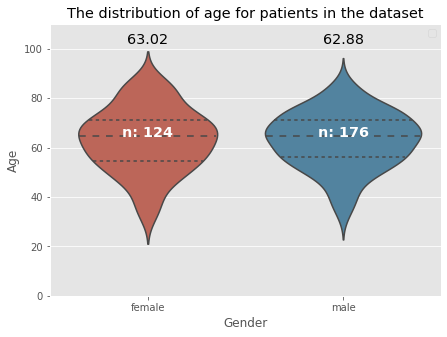

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
# distribution of age by gender
plt.style.use('ggplot')
groupedvalues = data.groupby('gender').agg('mean').reset_index()
# basic violinplot
plt.figure(figsize = (7,5))
ax = sns.violinplot(x="gender", y="age", data=data,
                    inner='quartile', palette=(['#CC5A49', '#4586AC']), order = ['female','male'])
# calculate the number of obs per group & median to position labels
medians = data.groupby(['gender'])['age'].median().values
mean = data.groupby(['gender'])['age'].mean().values
nobs = data['gender'].value_counts(sort = False).values
nobs = [str(x) for x in nobs.tolist()]
nobs = ["n: " + i for i in nobs]
# add it to the plot
pos = range(len(nobs))
for tick, label in zip(pos, ax.get_xticklabels()):
    ax.text(pos[tick], medians[tick] + 0.03, nobs[tick],
            horizontalalignment='center', size='x-large', color='w', weight='semibold')
for index, row in groupedvalues.iterrows():
    ax.text(row.name, 102, round(row.age, 2),
            color='black', ha="center", size='x-large')
plt.title("The distribution of age for patients in the dataset")
plt.xlabel('Gender')
plt.ylabel('Age')
plt.ylim([0, 110])
plt.legend()

In [ ]:
print('number of patients  = {}'.format(data['hn'].nunique()))
print('Mean (SD) age       = {:0.0f} ({:0.0f})'.format(data.age.mean(), data.age.std()))
print('Median (IQR) age    = {:0.0f} ({:0.0f}-{:0.0f})'.format(data.age.median(), data.age.quantile(0.25), data.age.quantile(0.75)))
print('Range (Min-Max)     = {}-{}'.format(data.age.min(), data.age.max()))

number of patients  = 300
Mean (SD) age       = 63 (12)
Median (IQR) age    = 64 (55-71)
Range (Min-Max)     = 31-89


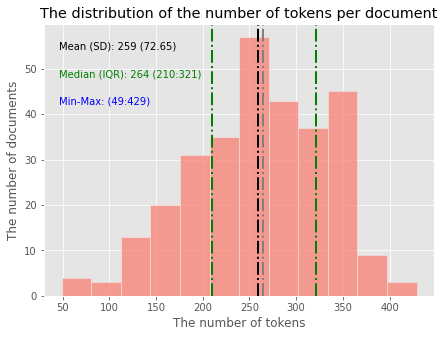

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
# number of tokens per chart
plt.style.use('ggplot')
plt.figure(figsize = (7,5))
ax = sns.histplot(data = data['len'], color = 'salmon')
ax.axvline(data['len'].mean(), color='black', linestyle='-.', linewidth=2)
ax.axvline(data['len'].median(), color='gray', linestyle='-.', linewidth=2)
ax.axvline(data['len'].quantile(0.25), color='green', linestyle='-.', linewidth=2)
ax.axvline(data['len'].quantile(0.75), color='green', linestyle='-.', linewidth=2)

ax.annotate('Mean (SD): {:0.0f} ({:0.2f})'.format(data['len'].mean(), data['len'].std()), 
            xy=(30, 0.85), xytext=(15, 15), 
            xycoords=('data', 'axes fraction'), textcoords='offset points', color='black'
            )
ax.annotate('Median (IQR): {:0.0f} ({:0.0f}:{:0.0f})'.format(data['len'].median(), data['len'].quantile(0.25), data['len'].quantile(0.75)), 
            xy=(30, 0.75), xytext=(15, 15), 
            xycoords=('data', 'axes fraction'), textcoords='offset points', color='green'
            )
ax.annotate('Min-Max: ({}:{})'.format(data['len'].min(), data['len'].max()), 
            xy=(30, 0.65), xytext=(15, 15), 
            xycoords=('data', 'axes fraction'), textcoords='offset points', color='blue'
            )   
plt.xlabel("The number of tokens")
plt.ylabel("The number of documents") 
plt.title("The distribution of the number of tokens per document")
plt.show()

## Dealing with multilingual
Discharge summaries from Ramathibodi hospital were written in mixed Thai-English languages, which most language models (LM) could not work on multilingual. There are two ways to handle multilingual problems, including <br>
1) remove Thai character entirely --> information will be lost about 20% (in our dataset) <br>
2) translate Thai to English --> we can utilize a high-performance machine translation,  Google Translate, which is the stage of the art (SOTA) for machine translation tasks with higher performance than humans. <br>
20% of information loss could be considered unacceptable, so we apply the second method in this workshop.

In [ ]:
## This language translation process will take some time to accomplish. In this workshop, The final dataset is also provided to download via Gdrive
# import pandas as pd
# import translators as trans
# from tqdm import tqdm
# tqdm.pandas()
# # translate thai to english using Google Traslate
# df['text_en'] = df['text'].progress_apply(lambda x: trans.google(x,from_language='th', to_language='en'))

# # Save dataframe as a .csv file for future use
# df[['hn', 'an', 'age', 'gender', 'label','text', 'text_prep', 'text_en', 
#     'len', 'len_th', 'len_en']].to_csv('colon_ca_dataset_translate.csv', index = False)

# URL for downloading the dataset
import pandas as pd
URL = "https://drive.google.com/file/d/10lLN_vgZF_FOrgEF7bh-Lr64EVM03xuU/view"
downloaded_URL = 'https://drive.google.com/uc?id=' + URL.split('/')[-2]

# download data
df = pd.read_csv(downloaded_URL, dtype = {'label' : int, 'age' : int, 'gender': int})
df[['hn','label','text','text_en']].sample(3, random_state = 1234)

,hn,label,text,text_en
164,wpXCk2hnwqrCm8Kc,0,Known case : double vessel disease s/p PCI ('5...,Known Case: Double Vessel Disease S/P PCI ('50...
200,wpXCmGxmwqnCncKi,0,"U/D - CKD stage5 - DM type2, HT, DLP - 2เดือ...","U/D - CKD Stage5 - DM Type2, HT, DLP - 2 month..."
73,wpPClWRrwrHCn8Ke,1,CC: นัดมาให้ยาเคมีบำบัด PI: known case locally...,CC: Make an appointment for chemotherapy. Pi: ...


## Data Characteristics

In [ ]:
import string
from pythainlp import word_tokenize

# check again
# combined text data from two features
# lower case
df['text_prep_en'] = df['text_en'].astype(str).str.lower()
df['text_prep_en'] = df['text_prep_en'].str.replace(r'\n', ' ').str.replace(r'\r', ' ')
# replace multiple white spaces with a single white space
df['text_prep_en'] = df['text_prep_en'].str.replace(r'^\s+|\s+$', '').str.replace(r'\s+', ' ')

# word tokenization: use Thai tokenizer from pythainlp
exc = ['\x84', ' '] + [*string.punctuation]
df['token_tran'] = df['text_prep_en'].apply(lambda x: word_tokenize(x, engine="newmm"))
df['token_tran'] = df['token_tran'].apply(lambda x : [ele for ele in x if ele not in exc])
    # count number of tokens
df['len_new'] = df['token_tran'].apply(len)

# vocabulary with all characters
vocab_tran = pd.Series([item for sublist in df.token_tran for item in sublist]).value_counts().reset_index()
# vocab size
print('The vocab size before translated to English = {}'.format(len(vocab_all)))
print('The vocab size after translated to English  = {}'.format(len(vocab_tran)))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: The default value of regex will change from True to False in a future version.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: The default value of regex will change from True to False in a future version.
  # Remove the CWD from sys.path while we load stuff.


The vocab size before translated to English = 6776
The vocab size after translated to English  = 7962


In [ ]:
df[['hn','label','len_new','text','text_prep_en']].sample(3, random_state = 1234)

,hn,label,len_new,text,text_prep_en
164,wpXCk2hnwqrCm8Kc,0,331,Known case : double vessel disease s/p PCI ('5...,known case: double vessel disease s/p pci ('50...
200,wpXCmGxmwqnCncKi,0,116,"U/D - CKD stage5 - DM type2, HT, DLP - 2เดือ...","u/d - ckd stage5 - dm type2, ht, dlp - 2 month..."
73,wpPClWRrwrHCn8Ke,1,285,CC: นัดมาให้ยาเคมีบำบัด PI: known case locally...,cc: make an appointment for chemotherapy. pi: ...


In [ ]:
from tableone import TableOne
data = df.copy()
data['gender'] = df['gender'].replace({1: 'male', 2: 'female'})
data['label'] = df['label'].replace({1: 'Yes', 0 : 'No'})

mytable = TableOne(data, columns=['age','gender','len_new','len','len_th', 'len_en', 'label'], 
                   categorical=['gender','label'], nonnormal=['len_new', 'len','len_th','len_en'], 
                   labels={'len': 'token length per document (raw data)', 'label' : 'Colon cancer',
                           'len_en':'token length per document (only En)', 
                           'len_th':'token length per document (only Th)',  
                           'len_new':'token length per document (translate)'})

print(mytable.tabulate(tablefmt = "fancy_grid"))
print('The vocab size       = {}'.format(len(vocab_tran)))
print('The number of tokens = {}'.format(data['len_new'].sum()))

/usr/local/lib/python3.7/dist-packages/tableone/tableone.py:226: DeprecationWarning: The labels argument is deprecated; use rename instead.
  "rename instead.", DeprecationWarning)


╒═══════════════════════════════════════════════════════╤════════╤═══════════╤═════════════════════╕
│                                                       │        │ Missing   │ Overall             │
╞═══════════════════════════════════════════════════════╪════════╪═══════════╪═════════════════════╡
│ n                                                     │        │           │ 300                 │
├───────────────────────────────────────────────────────┼────────┼───────────┼─────────────────────┤
│ age, mean (SD)                                        │        │ 0         │ 62.9 (12.1)         │
├───────────────────────────────────────────────────────┼────────┼───────────┼─────────────────────┤
│ gender, n (%)                                         │ female │ 0         │ 124 (41.3)          │
├───────────────────────────────────────────────────────┼────────┼───────────┼─────────────────────┤
│                                                       │ male   │           │ 176 (58.7)  

# Data management
There are four steps for preparing data; <br>
1) Data preprocessing --> the process of preparing the English textual data were performed. <br>
2) Data splitting --> the data will be split into three sets, training, validation, and test sets. <br>
3) Sequence padding --> to perform NLP, we need all documents to have the same length; thus, we add zeros in front of the first token shorter than the max length. <br>
4) Word vectorization --> each token will be mapped to a vector derived from pre-trained word embedding.


## 1) Data preprocessing
*   Stopword Removal --> Stopwords (e.g., "the", "a", "an", and "in") will be removed.
*   Punctuation Removal --> All punctuation will be removed.
*   Numerical Removal --> All number characters will be removed.
*   White spaces and new line Removal --> All multiple white spaces and new lines will be removed

In [ ]:
import nltk
# download stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
import re
import string
from nltk.corpus import stopwords
# create a set of stopwords and regex of punctuations
regex = re.compile('[%s]' % re.escape(string.punctuation))
print('Punctuation to remove =>> ' + string.punctuation)
print('\n')

stopWords = set(stopwords.words('english'))
# For every batch of 20 tokens...
print('Examples of stopword =>>')
for i in range(0, len(list(stopWords)), 20):
    # Limit the end index so we don't go past the end of the list.
    end = min(i + 20, len(list(stopWords)) + 1)
    # Print out the tokens, separated by a space.
    print(list(stopWords)[i:end])

Punctuation to remove =>> !"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


Examples of stopword =>>
['doing', 'no', 'too', 'who', 'having', 'himself', "isn't", 'its', 'against', 'did', 't', "couldn't", "should've", 're', 'were', 'have', 'under', 'm', "you've", 'during']
['then', 'all', 'before', 'o', 'own', 'very', 'why', 'was', 'wasn', 'once', 'this', 'couldn', 'hadn', "that'll", 'these', 'd', 'how', 'herself', 'mightn', 'yourselves']
['needn', 'there', 'to', 'or', 'hasn', "haven't", 'about', 'and', 'same', 've', "needn't", 'his', 'if', 'them', 'he', 'on', 'here', 'your', 'are', 'than']
["mustn't", 'not', 'won', 'y', 'by', 'further', 'being', 'into', 'now', 'can', 's', 'don', 'me', "she's", 'hers', 'll', 'each', 'ain', 'over', 'but']
["hasn't", 'will', 'until', 'both', 'doesn', 'what', 'any', 'should', 'weren', 'up', 'where', 'other', 'those', "wasn't", 'him', 'yourself', 'she', 'am', 'down', 'be']
['it', "don't", 'nor', 'with', "won't", 'our', "shan't", 'wouldn', 'ourselves', 'ours', 'yours', 'bec

In [ ]:
import re
# remove stopword
df['text_use'] = df['text_prep_en'].apply(lambda x: " ".join(x for x in x.split() if x not in stopWords))
# replace punctuation with white space
df['text_use'] = df['text_use'].apply(lambda x : regex.sub(' ', x))
# replace number with white space
df['text_use'] = df['text_use'].str.replace(r'\d+', ' ')
# replace new line with white space
df['text_use'] = df['text_use'].str.replace(r'\n', ' ').str.replace(r'\r', ' ')
# replace multiple white spaces with a single white space
df['text_use'] = df['text_use'].str.replace(r'^\s+|\s+$', '').str.replace(r'\s+', ' ')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: The default value of regex will change from True to False in a future version.
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: The default value of regex will change from True to False in a future version.
  # This is added back by InteractiveShellApp.init_path()


In [ ]:
# check example of data point
df[['hn','label','text_prep_en','text_use']].sample(3, random_state = 1234)

,hn,label,text_prep_en,text_use
164,wpXCk2hnwqrCm8Kc,0,known case: double vessel disease s/p pci ('50...,known case double vessel disease s p pci come ...
200,wpXCmGxmwqnCncKi,0,"u/d - ckd stage5 - dm type2, ht, dlp - 2 month...",u d ckd stage dm type ht dlp months tiredness ...
73,wpPClWRrwrHCn8Ke,1,cc: make an appointment for chemotherapy. pi: ...,cc make appointment chemotherapy pi known case...


## 2) Data splitting
The dataset was split into three sets, including training, validation, and test sets with a splitting ratio of 60: 20: 20

In [ ]:
from sklearn.model_selection import train_test_split
X = df[['hn','text', 'text_prep_en','text_use']]
y = df['label'].astype(int).values

def split(X, y, test_size=0.20):
    Xtrn, Xtst, ytrn, ytst = train_test_split(X, y, test_size=test_size,
                                              random_state=6, stratify=y)
    return Xtrn, Xtst, ytrn, ytst

train_data, test_data, y_train, y_test = split(X, y, test_size=0.20)
train_data, val_data, y_train, y_val = split(train_data, y_train, test_size=0.250)

train_data = train_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)
val_data = val_data.reset_index(drop=True)

print('# of patients with colon CA in train data    = {}'.format(y_train.sum()))
print('# of patients with colon CA in validate data = {}'.format(y_val.sum()))
print('# of patients with colon CA in test data     = {}'.format(y_test.sum()))

# of patients with colon CA in train data    = 90
# of patients with colon CA in validate data = 30
# of patients with colon CA in test data     = 30


 ## 3) Sequence padding
 The sequence padding makes input data has a same length.

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
## token and padding
def token_pad(X_trn, X_tst, X_val, col):
    tokenizer = Tokenizer(split=' ')
    tokenizer.fit_on_texts(X_trn[col])

    X_trn = tokenizer.texts_to_sequences(X_trn[col])
    X_trn = pad_sequences(X_trn, maxlen=maxlen, padding="pre")

    X_tst = tokenizer.texts_to_sequences(X_tst[col])
    X_tst = pad_sequences(X_tst, maxlen=maxlen, padding="pre")

    X_val = tokenizer.texts_to_sequences(X_val[col])
    X_val = pad_sequences(X_val, maxlen=maxlen, padding="pre")
    return X_trn, X_tst, X_val, tokenizer

# find max_len
maxlen = max(train_data['text_use'].str.split().str.len().max(),
              test_data['text_use'].str.split().str.len().max(),
              val_data['text_use'].str.split().str.len().max()
              )
print('max length = {}'.format(maxlen))

X_trn, X_tst, X_val, tokenizer = token_pad(train_data, test_data, val_data, 'text_use')

max length = 241


In [ ]:
import textwrap
print('This is what our input data look like')
print('\n')
print(X_tst[0:1])
print('\n')
textwrap.wrap(tokenizer.sequences_to_texts(X_tst[0:1])[0],70)

This is what our input data look like


[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0   43
    19    6   89   70  430  153  124 4822  263   44   49  830   41  365
   333    8  135   65    2  108   10   89   70  620  117  430  614  153
   262 1999  314  430  173   42  234  718 1797  121 4420 1001  886  830
  4384  656   32   70   

['known case ca sigmoid colon colonic obstruction pt pn b m dx dec',
 'present abdominal constipation ct whole abdomen cm circumferential',
 'mass sigmoid colon causing distal colonic gut obstruction likely',
 'representing primary colonic cancer small free fluid perihepatic',
 'bilateral paracolic pelvic set dec hartman operation patho colon',
 'sigmoid sigmoidectomy adenocarcinoma moderately differentiated size x',
 'x cm location sigmoid colon tumor invades muscularis propria pericolic',
 'tissue metastasis regional lymph nodes examined presence perineural',
 'invasion admission first cmt folfox normal symptoms fever feces',
 'normally abdomen dry problem known case case ca sigmoid colon colonic',
 'obstruction pt pn b m admission first cycle folfox com']

In [ ]:
print('What about the raw data?')
print('\n')
textwrap.wrap(test_data['text'][0:1][0],70)

What about the raw data?




['known case CA sigmoid colon with colonic obstruction pT3pN2b M0 DX on',
 'DEC 2014 present with abdominal discomfort and constipation  CT whole',
 'abdomen = - A 2.6-cm circumferential mass at sigmoid colon causing',
 'distal colonic gut obstruction; likely representing primary colonic',
 'cancer.  - Small free fluid at perihepatic, bilateral paracolic',
 'gutters, pelvic cavity, and interbowel loops.  set OR for surger on 7',
 'DEC 2014 for hartman operation  patho= >>  Colon, sigmoid,',
 'sigmoidectomy:     - Adenocarcinoma, moderately differentiated.     -',
 'Size: 4.7x3.5x1 cm.     - Location: sigmoid colon     - Tumor invades',
 'through the muscularis propria into       pericolic tissue.     -',
 'Metastasis in 13 out of 24 regional lymph nodes examined.     - Free',
 'proximal and distal margins.     - Mesenteric resection margin is',
 'uninvolved by carcinoma.     - Presence of angiolymphatic invasion.',
 '- Presence of perineural invasion. this admission for first CMT',
 's

##4) Word vectorization
Word embedding, also called word vectors, is one of the powerful ways to convert unstructured data (text data) to structure data (set of word vectors). In this workshop, we use GloVe (Global Vectors for Word Representation) with 50 dimensions as small vectors could consume little computational time compared to the largest one with 300 dimensions

In [ ]:
# find vocab_size
tokenizer = Tokenizer(split=' ')
tokenizer.fit_on_texts(train_data['text_use'])
vocab_size = len(tokenizer.word_index) + 1

In [ ]:
# # download word embedding from Stanford website
# !wget http://nlp.stanford.edu/data/glove.6B.zip
# !unzip -q glove.6B.zip
# download word embedding from our Gdrive
    # GloVe 50d --> Gdrive ID --> 11Kd1goVYMlV-RwvgWvKO_RM7y8owM1hH
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=11Kd1goVYMlV-RwvgWvKO_RM7y8owM1hH' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=11Kd1goVYMlV-RwvgWvKO_RM7y8owM1hH" -O glove.6B.50d.txt && rm -rf /tmp/cookies.txt

--2022-11-24 21:01:09--  https://docs.google.com/uc?export=download&confirm=t&id=11Kd1goVYMlV-RwvgWvKO_RM7y8owM1hH
Resolving docs.google.com (docs.google.com)... 173.194.202.138, 173.194.202.100, 173.194.202.139, ...
Connecting to docs.google.com (docs.google.com)|173.194.202.138|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0k-30-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/b9tng83hm7csrorlkqdu233bcl1fgpbf/1669323600000/04037358690023703984/*/11Kd1goVYMlV-RwvgWvKO_RM7y8owM1hH?e=download&uuid=72017176-8008-4ea2-8b47-016ea0aa451e [following]
--2022-11-24 21:01:09--  https://doc-0k-30-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/b9tng83hm7csrorlkqdu233bcl1fgpbf/1669323600000/04037358690023703984/*/11Kd1goVYMlV-RwvgWvKO_RM7y8owM1hH?e=download&uuid=72017176-8008-4ea2-8b47-016ea0aa451e
Resolving doc-0k-30-docs.googleusercontent.com (doc-0k-30-docs.googleusercontent.com)... 74.125.195.1

In [ ]:
# load GloVe 50d
print('Indexing word vectors.')
embeddings_index = {}
f = open('glove.6B.50d.txt', encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Indexing word vectors.
Found 400000 word vectors.


In [ ]:
# example of word embedding of colon cancer
print('word embedding of colon')
print(embeddings_index.get('colon'))

print('word embedding of ca')
print(embeddings_index.get('ca'))

word embedding of colon
[ 1.9137    0.47635  -0.6712    0.23161  -0.86501   0.84549   0.21972
  0.45263  -0.25099   1.0109    0.39744  -0.28823   0.49985   0.31242
  0.098489 -0.81182  -0.98713  -0.841    -0.66722   0.83348  -1.7008
 -0.86019   0.2184   -0.49378  -0.82789  -0.28881   0.91468   0.40346
  0.15966  -1.0956    1.0588    0.57971  -0.072896 -0.43461  -0.50694
 -0.067438  0.66655   0.95299   1.6794    0.025161 -0.65725  -0.049377
  0.16535   0.52263   0.37249  -0.28524   0.40771  -1.1498    0.19839
  0.68004 ]
word embedding of ca
[ 0.028222 -0.072881  0.56781  -0.29649   0.08538  -0.78858  -0.20837
  0.22496  -0.55122   0.29046  -0.22736   0.6031   -0.21876  -0.33138
  0.92313   0.83643   0.47158   0.18449   0.35594  -0.83259  -0.51416
  0.282     0.36725   0.74079   0.59935  -1.8163   -1.0256   -0.095992
  0.91687  -1.2579    2.8979    0.68416  -0.78139  -0.18432  -0.14208
 -0.474     0.10048  -0.17088   1.0221   -0.62035  -0.19287  -0.076375
  0.42848   0.73572  -0.10176  

In [ ]:
# map to study vocabulary
# Create a weight matrix
embedding_dim = 50
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    if i > vocab_size:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [ ]:
list(tokenizer.word_index.items())[:10]

[('s', 1),
 ('cm', 2),
 ('p', 3),
 ('metastasis', 4),
 ('rectum', 5),
 ('ca', 6),
 ('cycle', 7),
 ('ct', 8),
 ('normal', 9),
 ('mass', 10)]

# Model Development
This workshop will create 2 deep learning models <br>
*   Gated recurrent unit (GRU) model, a variant type of RNN model developed by Kyunghyun Cho et al. in 2014.
*   Bidirectional Encoder Representations from Transformers (BERT) model, pre-trained BERT on a medical domain (PubMedBERT) will be fine-tuned. BERT is considered the SOTA model for text classification problems.



## GRU model

In [ ]:
import keras
from keras.initializers import Constant
from keras.layers import Dense, Dropout, Embedding, GRU, BatchNormalization
from keras.models import Sequential
# GRU model architecture
def GRU_model(n_hidden=1, units=1, unitout=1, dropout=0, optimizer='Adam'):
    model = Sequential()
    embedding_layer = Embedding(vocab_size,
                                embedding_dim,
                                embeddings_initializer=Constant(
                                    embedding_matrix),
                                input_length=maxlen,
                                trainable=False)
    model.add(embedding_layer)
    model.add(BatchNormalization())
    model.add(Dropout(dropout))
    for layer in range(n_hidden):
        model.add(GRU(units=int(units), return_sequences=True))
        model.add(Dropout(dropout))
    model.add(GRU(units=int(unitout)))
    model.add(Dropout(dropout))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy',
                  optimizer=optimizer, metrics=["acc"])
    return model

In [ ]:
def modeling(model, Xtrn, Xval, ytrn, yval, epochs, batch_size, model_name):
    # apply early stop at 10 times validation loss has no improvement
    early_stopping = keras.callbacks.EarlyStopping(patience=10, min_delta=0, 
                                                   restore_best_weights=True, monitor='val_loss')
    model.save('{}.h5'.format(model_name))
    checkpoint = keras.callbacks.ModelCheckpoint('{}.h5'.format(model_name), 
                                                 monitor='val_loss', 
                                                 save_best_only=True)
    history = model.fit(Xtrn, ytrn, epochs=epochs, batch_size=batch_size,
                        callbacks=[early_stopping, checkpoint], verbose=1,
                        validation_data=(Xval, yval))
    return history

In [ ]:
gru_model = GRU_model(n_hidden=2,units=32,unitout=16, dropout = 0.4,
                      optimizer=tf.keras.optimizers.Adam(learning_rate=0.0009))
# check model architecture
gru_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 241, 50)           253700    
                                                                 
 batch_normalization (BatchN  (None, 241, 50)          200       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 241, 50)           0         
                                                                 
 gru (GRU)                   (None, 241, 32)           8064      
                                                                 
 dropout_1 (Dropout)         (None, 241, 32)           0         
                                                                 
 gru_1 (GRU)                 (None, 241, 32)           6336      
                                                        

In [ ]:
# # model training would take about 5 minutes. We already provided the trained model checkpoint that can download from Gdrive
# import time
# start = time.time()
# history_gru = modeling(gru_model,X_trn, X_val, y_train, y_val, 
#                        epochs = 50, batch_size = 16, model_name = 'gru_model')
# t = time.time() - start
# history_gru.model.save(r'gru_model.pkl')

Epoch 1/50 <br>
12/12 [==============================] - 20s 449ms/step - loss: 0.6788 - acc: 0.5722 - val_loss: 0.6790 - val_acc: 0.5833 <br>
Epoch 2/50 <br>
12/12 [==============================] - 4s 337ms/step - loss: 0.6756 - acc: 0.5778 - val_loss: 0.6600 - val_acc: 0.6500 <br>

.................... <br>
.................... <br>
 
Epoch 23/50 <br>
12/12 [==============================] - 6s 469ms/step - loss: 0.2915 - acc: 0.8778 - val_loss: 0.4490 - val_acc: 0.8500 <br>
Epoch 24/50 <br>
12/12 [==============================] - 4s 303ms/step - loss: 0.2802 - acc: 0.9167 - val_loss: 0.4940 - val_acc: 0.8167 <br>
Epoch 25/50 <br>
12/12 [==============================] - 4s 309ms/step - loss: 0.2648 - acc: 0.9000 - val_loss: 0.5103 - val_acc: 0.8000 <br>

.................... <br>
.................... <br>
Epoch 32/50 <br>
12/12 [==============================] - 4s 317ms/step - loss: 0.3145 - acc: 0.8833 - val_loss: 0.4724 - val_acc: 0.8500 <br>
Epoch 33/50 <br>
12/12 [==============================] - 4s 313ms/step - loss: 0.2380 - acc: 0.9167 - val_loss: 0.5217 - val_acc: 0.8167

In [ ]:
# pd.DataFrame(pd.concat([pd.DataFrame(history_gru.history['loss'], columns =['loss']), pd.DataFrame(history_gru.history['val_loss'], columns =['val_loss'])], axis = 1)).plot(figsize=(8, 5))
# plt.grid(True)
# plt.gca()
# plt.title('The comparison between train and validate loss of GRU model')
# plt.show()

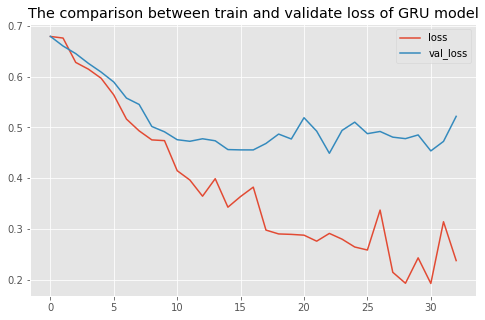

In [ ]:
# print("The computational time for GRU model is " +
#       str((round(t/60, 2))) + " minutes")

The computational time for GRU model is 2.11 minutes

In [ ]:
# # save model
# from google.colab import files
# !zip -r /content/gru_model.zip /content/gru_model.pkl
# files.download("/content/gru_model.zip")

In [ ]:
# # load model
# gru model --> Gdrive ID --> 11edVCVPb8BSk0x9ymF3EFSJe4-IuO8p2
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=11edVCVPb8BSk0x9ymF3EFSJe4-IuO8p2' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=11edVCVPb8BSk0x9ymF3EFSJe4-IuO8p2" -O gru_model.zip && rm -rf /tmp/cookies.txt
!unzip /content/gru_model.zip -d /
gru_model = keras.models.load_model(r'gru_model.pkl')

--2022-11-24 21:01:28--  https://docs.google.com/uc?export=download&confirm=&id=11edVCVPb8BSk0x9ymF3EFSJe4-IuO8p2
Resolving docs.google.com (docs.google.com)... 173.194.202.138, 173.194.202.100, 173.194.202.139, ...
Connecting to docs.google.com (docs.google.com)|173.194.202.138|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-14-30-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/743gg064npcmf2bv2dqcd8ib9i6qqf1p/1669323675000/04037358690023703984/*/11edVCVPb8BSk0x9ymF3EFSJe4-IuO8p2?e=download&uuid=298efff5-a2f5-437e-bb87-09f428865266 [following]
--2022-11-24 21:01:28--  https://doc-14-30-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/743gg064npcmf2bv2dqcd8ib9i6qqf1p/1669323675000/04037358690023703984/*/11edVCVPb8BSk0x9ymF3EFSJe4-IuO8p2?e=download&uuid=298efff5-a2f5-437e-bb87-09f428865266
Resolving doc-14-30-docs.googleusercontent.com (doc-14-30-docs.googleusercontent.com)... 74.125.195.13

## BERT model

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
    # BERT preprocessing
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
    # BERT architecture with PubMed weight
bert_encoder = hub.KerasLayer('https://tfhub.dev/google/experts/bert/pubmed/2', trainable=False)

In [ ]:
# BERT
def BERT_model(dropout=0.4, optimizer='Adam'):
    # Bert layers
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessed_text = bert_preprocess(text_input)
    outputs = bert_encoder(preprocessed_text)

    # Neural network layers
    l = tf.keras.layers.Dropout(dropout, name="dropout")(outputs['pooled_output'])
    l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

    # Use inputs and outputs to construct a final model
    model = tf.keras.Model(inputs=[text_input], outputs = [l])
    model.compile(loss='binary_crossentropy',
                       optimizer=optimizer, metrics=["acc"])
    return model

In [ ]:
bert_model = BERT_model(dropout = 0.4, optimizer=tf.keras.optimizers.Adam(learning_rate=0.0009))
bert_model.save('bert_model.h5')
checkpoint = keras.callbacks.ModelCheckpoint('bert_model.h5', 
                                                monitor='val_loss', 
                                                save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=10, min_delta=0, 
                                                restore_best_weights=True, monitor='val_loss')
bert_model.summary(0)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_type_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                      

In [ ]:
# import time
# start = time.time()
# history_bert = bert_model.fit(train_data['text_use'], y_train, verbose=1,
#                               epochs = 50, batch_size = 16, 
#                               callbacks = [checkpoint,early_stopping],
#                               validation_data = (val_data['text_use'], y_val))
# t = time.time() - start
# history_bert.model.save(r'bert_model.pkl')

Epoch 1/50 <br>
12/12 [==============================] - 120s 9s/step - loss: 0.7422 - acc: 0.5278 - val_loss: 0.6165 - val_acc: 0.6833 <br>
Epoch 2/50 <br>
12/12 [==============================] - 114s 10s/step - loss: 0.6097 - acc: 0.6722 - val_loss: 0.5700 - val_acc: 0.7500 <br>
Epoch 3/50 <br>
12/12 [==============================] - 125s 11s/step - loss: 0.6129 - acc: 0.6833 - val_loss: 0.5373 - val_acc: 0.7667 <br>
Epoch 4/50 <br>
12/12 [==============================] - 109s 9s/step - loss: 0.5882 - acc: 0.7000 - val_loss: 0.5140 - val_acc: 0.8000 <br>
.................... <br>
.................... <br>
Epoch 46/50 <br>
12/12 [==============================] - 124s 11s/step - loss: 0.2594 - acc: 0.9000 - val_loss: 0.3253 - val_acc: 0.8833 <br>
Epoch 47/50 <br>
12/12 [==============================] - 120s 10s/step - loss: 0.2474 - acc: 0.9111 - val_loss: 0.3294 - val_acc: 0.8667 <br>
Epoch 48/50 <br>
12/12 [==============================] - 120s 10s/step - loss: 0.2535 - acc: 0.9167 - val_loss: 0.3423 - val_acc: 0.8500 <br>
Epoch 49/50 <br>
12/12 [==============================] - 124s 11s/step - loss: 0.2485 - acc: 0.8889 - val_loss: 0.3217 - val_acc: 0.8667 <br>
Epoch 50/50 <br>
12/12 [==============================] - 120s 10s/step - loss: 0.2619 - acc: 0.8833 - val_loss: 0.3227 - val_acc: 0.8667

In [ ]:
# pd.DataFrame(pd.concat([pd.DataFrame(history_bert.history['loss'], columns =['loss']), pd.DataFrame(history_bert.history['val_loss'], columns =['val_loss'])], axis = 1)).plot(figsize=(8, 5))
# plt.grid(True)
# plt.gca()
# plt.title('The comparison between train and validate loss of BERT model')
# plt.show()

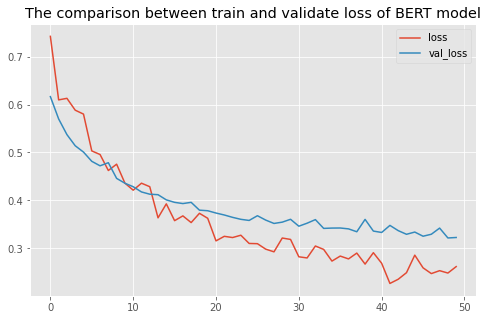

In [ ]:
# print("The computational time for BERT model is " +
#       str((round(t/60, 2))) + " minutes")

The computational time for BERT model is 100.54 minutes

In [ ]:
# # save model
# from google.colab import files
# !zip -r /content/bert_model.zip /content/bert_model.pkl
# files.download("/content/bert_model.zip")

In [ ]:
# # load model
# load from Gdrive
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1uZQAHULLolgUAOy0vM12PtokqJ1Jr6pK' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1uZQAHULLolgUAOy0vM12PtokqJ1Jr6pK" -O bert_model.zip && rm -rf /tmp/cookies.txt
!unzip /content/bert_model.zip -d /
bert_model = keras.models.load_model(r'bert_model.pkl')

--2022-11-24 21:02:04--  https://docs.google.com/uc?export=download&confirm=t&id=1uZQAHULLolgUAOy0vM12PtokqJ1Jr6pK
Resolving docs.google.com (docs.google.com)... 173.194.202.139, 173.194.202.102, 173.194.202.138, ...
Connecting to docs.google.com (docs.google.com)|173.194.202.139|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0c-98-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/lrro2joe2m6usc230j0hm0idklb79d38/1669323675000/06069578665764315964/*/1uZQAHULLolgUAOy0vM12PtokqJ1Jr6pK?e=download&uuid=f60ab07c-239e-440a-9925-a9ce82daaf1e [following]
--2022-11-24 21:02:04--  https://doc-0c-98-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/lrro2joe2m6usc230j0hm0idklb79d38/1669323675000/06069578665764315964/*/1uZQAHULLolgUAOy0vM12PtokqJ1Jr6pK?e=download&uuid=f60ab07c-239e-440a-9925-a9ce82daaf1e
Resolving doc-0c-98-docs.googleusercontent.com (doc-0c-98-docs.googleusercontent.com)... 74.125.195.1

# Model Evaluation
In the workshop, the dataset was randomly selected to be balanced between colon cancer and non-colon cancer patients. So, the model evaluation uses accuracy as the main metric to assess model performance. In addition, precision, recall, F1, AUROC, and AUPRC also were analyzed for both GRU and BERT models.

In [ ]:
from sklearn.metrics import  roc_curve, precision_recall_curve, roc_auc_score, average_precision_score, confusion_matrix, f1_score, recall_score, precision_score, accuracy_score
def evaluation(model, Xtrn, Xtst, ytrn, ytst):
    # evaluation
      # find the optimal threshold using ROC
    _y_prob = model.predict(Xtrn)
    _fpr, _tpr, _thres = roc_curve(ytrn, _y_prob)
    _th_prec, _th_rec, _ = precision_recall_curve(ytrn, _y_prob, pos_label=1)
    opt_thres = _thres[np.argmax(_tpr - _fpr)]
      # prediction
    _y_pred = (_y_prob >= opt_thres).astype('int32')

      # metrics for training data
    _auroc = roc_auc_score(ytrn, _y_prob)
    _auprc = average_precision_score(ytrn, _y_prob)
    _cmat = confusion_matrix(y_pred=_y_pred, y_true=ytrn, labels=[1, 0])
    _acc = accuracy_score(_y_pred, ytrn)
    _f1 = f1_score(_y_pred, ytrn)
    _rec = recall_score(_y_pred, ytrn)
    _prec = precision_score(_y_pred, ytrn)

      # metrics for test data
        # predict probability
    y_prob = model.predict(Xtst)
        # prediction
    y_pred = (y_prob > opt_thres).astype('int32')
    fpr, tpr, _ = roc_curve(ytst, y_prob, pos_label=1)
    th_prec, th_rec, _ = precision_recall_curve(ytst, y_prob, pos_label=1)
        # other metrics
    auroc = roc_auc_score(ytst, y_prob)
    auprc = average_precision_score(ytst, y_prob)
    cmat = confusion_matrix(y_pred=y_pred, y_true=ytst, labels=[1, 0])
    acc = accuracy_score(y_pred, ytst)
    f1 = f1_score(y_pred, ytst)
    rec = recall_score(y_pred, ytst)
    prec = precision_score(y_pred, ytst)
        # save metrics
    dic = {}
    dic["metrics"] = {
                      'fpr': fpr,'tpr': tpr, 'fpr_trn': _fpr,'tpr_trn': _tpr, 
                      'th_prec': th_prec, 'th_rec': th_rec, 
                      'th_prec_trn': _th_prec, 'th_rec_trn': _th_rec, 
                      'cmat': cmat, 'cmat_trn': _cmat, 
                      'auroc': auroc, 'auprc': auprc, 'auroc_trn': _auroc, 'auprc_trn': _auprc,
                      'acc': acc, 'acc_trn': _acc, 'f1':f1, 'f1_trn': _f1,
                      'rec': rec, 'rec_trn': _rec, 'prec': prec, 'prec_trn': _prec,
                      }
    return dic

dic_eva_gru = evaluation(
    gru_model, X_trn, X_tst, y_train, y_test)

dic_eva_bert = evaluation(
    bert_model, train_data['text_use'], test_data['text_use'], y_train, y_test)

2/2 [==============================] - 26s 12s/step


## Comparing model performance

We could see that GRU and BERT models performed similarly in training data, but for the test data, the BERT model performed better.

<Figure size 432x288 with 0 Axes>

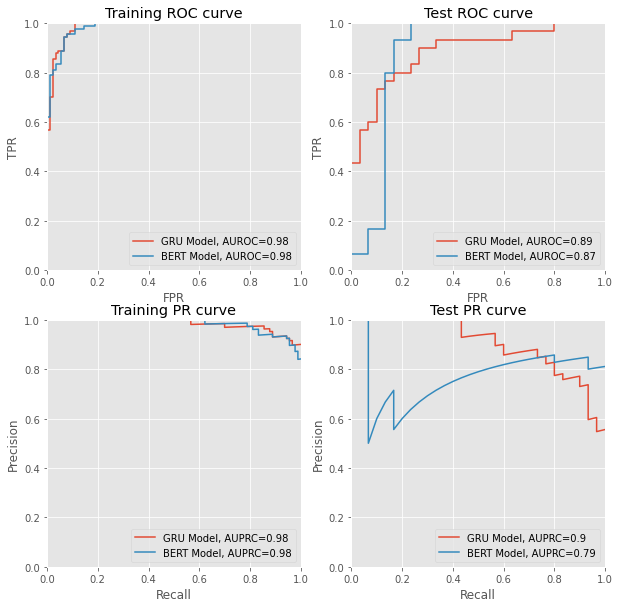

In [ ]:
# Comparing the ROC curve and PR curve for training and test data
  # set the figure layout
plt.figure(0).clf()
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 10))
  # training ROC
ax1.plot(dic_eva_gru["metrics"]['fpr_trn'], dic_eva_gru["metrics"]['tpr_trn'],
         label="GRU Model, AUROC=" + str(round(dic_eva_gru["metrics"]['auroc_trn'], 2)))
ax1.plot(dic_eva_bert["metrics"]['fpr_trn'], dic_eva_bert["metrics"]['tpr_trn'],
         label="BERT Model, AUROC=" + str(round(dic_eva_bert["metrics"]['auroc_trn'], 2)))
ax1.set_xlabel("FPR")
ax1.set_ylabel("TPR")
ax1.set_title("Training ROC curve")
ax1.set_xlim(left=0, right=1)
ax1.set_ylim(bottom=0, top=1)
ax1.legend(loc="lower right")
  # training PR
ax3.plot(dic_eva_gru["metrics"]['th_rec_trn'], dic_eva_gru["metrics"]['th_prec_trn'],
        label="GRU Model, AUPRC=" + str(round(dic_eva_gru["metrics"]['auprc_trn'], 2)))
ax3.plot(dic_eva_bert["metrics"]['th_rec_trn'], dic_eva_bert["metrics"]['th_prec_trn'],
        label="BERT Model, AUPRC=" + str(round(dic_eva_bert["metrics"]['auprc_trn'], 2)))
ax3.set_xlabel("Recall")
ax3.set_ylabel("Precision")
ax3.set_title("Training PR curve")
ax3.set_xlim(left=0, right=1)
ax3.set_ylim(bottom=0, top=1)
ax3.legend(loc="lower right")
  # test ROC
ax2.plot(dic_eva_gru["metrics"]['fpr'], dic_eva_gru["metrics"]['tpr'],
         label="GRU Model, AUROC=" + str(round(dic_eva_gru["metrics"]['auroc'], 2)))
ax2.plot(dic_eva_bert["metrics"]['fpr'], dic_eva_bert["metrics"]['tpr'],
         label="BERT Model, AUROC=" + str(round(dic_eva_bert["metrics"]['auroc'], 2)))
ax2.set_xlabel("FPR")
ax2.set_ylabel("TPR")
ax2.set_title("Test ROC curve")
ax2.set_xlim(left=0, right=1)
ax2.set_ylim(bottom=0, top=1)
ax2.legend(loc="lower right")
  # test PR
ax4.plot(dic_eva_gru["metrics"]['th_rec'], dic_eva_gru["metrics"]['th_prec'],
        label="GRU Model, AUPRC=" + str(round(dic_eva_gru["metrics"]['auprc'], 2)))
ax4.plot(dic_eva_bert["metrics"]['th_rec'], dic_eva_bert["metrics"]['th_prec'],
        label="BERT Model, AUPRC=" + str(round(dic_eva_bert["metrics"]['auprc'], 2)))
ax4.set_xlabel("Recall")
ax4.set_ylabel("Precision")
ax4.set_title("Test PR curve")
ax4.set_xlim(left=0, right=1)
ax4.set_ylim(bottom=0, top=1)
ax4.legend(loc="lower right")
plt.show()

BERT and GRU models perform outstandingly in training data with AUROC and AUPRC of 98. However, performances (both AUROC and AUPRC) decreased by about 10% when applying the GRU model to the test data. For the BERT model, the AUROC score decrease similarly to the GRU model, but the AUPRC score drops significantly by ~20%. 

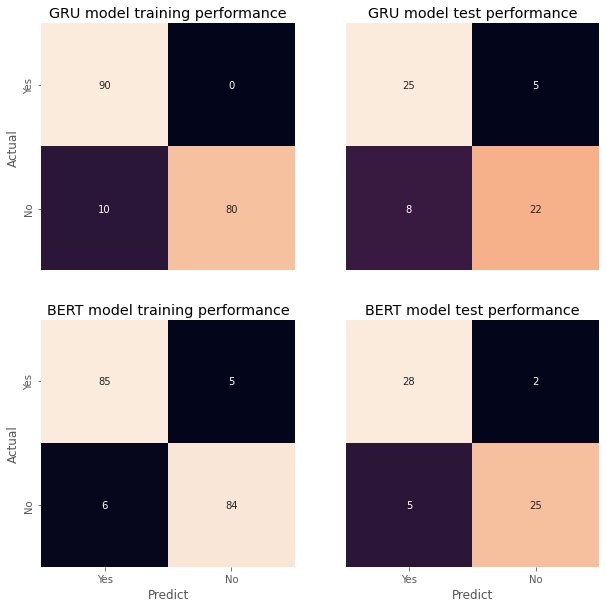

In [ ]:
# confusion metrics of train and test data for GRU and BERT model
cm1 = pd.DataFrame(dic_eva_gru["metrics"]['cmat_trn'], index=['Positive', 'Negative'], columns=['Positive', 'Negative'])
cm2 = pd.DataFrame(dic_eva_gru["metrics"]['cmat'], index=['Positive', 'Negative'], columns=['Positive', 'Negative'])
cm3 = pd.DataFrame(dic_eva_bert["metrics"]['cmat_trn'], index=['Positive', 'Negative'], columns=['Positive', 'Negative'])
cm4 = pd.DataFrame(dic_eva_bert["metrics"]['cmat'], index=['Positive', 'Negative'], columns=['Positive', 'Negative'])

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 10))
sns.heatmap(cm1, annot=True, ax=ax1, figure=fig, cmap='rocket',
            xticklabels=False, yticklabels=['Yes','No'], 
            cbar=False)
sns.heatmap(cm2, annot=True, ax=ax2, figure=fig, cmap='rocket',
            xticklabels=False, yticklabels=False, 
            cbar=False)
sns.heatmap(cm3, annot=True, ax=ax3, figure=fig, cmap='rocket',
            xticklabels=['Yes','No'], yticklabels=['Yes','No'], 
            cbar=False)
sns.heatmap(cm4, annot=True, ax=ax4, figure=fig, cmap='rocket',
            xticklabels=['Yes','No'], yticklabels=False, 
            cbar=False)
ax1.set_ylabel('Actual')
ax3.set_ylabel('Actual')
ax3.set_xlabel('Predict')
ax4.set_xlabel('Predict')
ax1.set_title(r'GRU model training performance')
ax2.set_title(r'GRU model test performance')
ax3.set_title(r'BERT model training performance')
ax4.set_title(r'BERT model test performance')
plt.show()

In terms of AUROC and AUPRC scores, the GRU model performed better than the BERT model both training and test data.

In [ ]:
# create dataframe to represent model evaluation
key_trn = ['acc_trn',  'f1_trn', 'rec_trn',  'prec_trn']
key_tst = ['acc', 'f1', 'rec', 'prec']
dict_bert_trn = {key: dic_eva_bert['metrics'][key] for key in key_trn}
dict_gru_trn = {key: dic_eva_gru['metrics'][key] for key in key_trn}
dict_bert_tst = {key: dic_eva_bert['metrics'][key] for key in key_tst}
dict_gru_tst = {key: dic_eva_gru['metrics'][key] for key in key_tst}

data_print1 = pd.concat([pd.DataFrame.from_dict(dict_gru_trn, orient='index'), pd.DataFrame.from_dict(dict_bert_trn, orient='index')],axis = 1)
data_print2 = pd.concat([pd.DataFrame.from_dict(dict_gru_tst, orient='index'), pd.DataFrame.from_dict(dict_bert_tst, orient='index')],axis = 1)
data_print = pd.concat([data_print1,data_print2],axis = 0)
data_print.columns = ['GRU model', 'BERT model']

data_diff = pd.DataFrame()
data_diff['diff%_GRU'] = (data_print[data_print.index.str.contains('trn')]['GRU model'].values - data_print[~data_print.index.str.contains('trn')]['GRU model'].values)*100 / data_print[data_print.index.str.contains('trn')]['GRU model'].values
data_diff['diff%_BERT'] = (data_print[data_print.index.str.contains('trn')]['BERT model'].values - data_print[~data_print.index.str.contains('trn')]['BERT model'].values)*100 / data_print[data_print.index.str.contains('trn')]['BERT model'].values

data_print1 = data_print[data_print.index.str.contains('trn')].reset_index()
data_print2 = data_print[~data_print.index.str.contains('trn')].reset_index(drop = True)
data_print = pd.concat([data_print1, data_print2,data_diff], axis = 1)
data_print = data_print.round(4)

columns=[('metrics',''),('Training data','GRU'),('Training data','BERT'),
         ('Test data','GRU'),('Test data','BERT'),
         ('differnce%','GRU'),('differnce%','BERT'),
]
data_print.columns = pd.MultiIndex.from_tuples(columns)
data_print

metrics Training data         Test data         differnce%        
                      GRU    BERT       GRU    BERT        GRU    BERT
0   acc_trn        0.9444  0.9389    0.7833  0.8833    17.0588  5.9172
1    f1_trn        0.9474  0.9392    0.7937  0.8889    16.2257  5.3595
2   rec_trn        0.9000  0.9341    0.7576  0.8485    15.8249  9.1622
3  prec_trn        1.0000  0.9444    0.8333  0.9333    16.6667  1.1765

### conclusion
The GRU model is more likely to be overfitting, indicated by a percent difference between training and test performance of all metrics, which are about 15%-17%. Conversely, the BERT model provides significantly better performance (~10% for all metrics) and is less likely to be overfitting, with a percent difference of less than 10% for all metrics. <br><br>
### suggestion
The GRU model yield higher performance for AUROC and AUPRC scores, but when applying optimal threshold for classifying colon cancer, accuracy, f1, recall, and precision scores are not in line with the main evaluation metrics (AUROC and AUPRC). However, the GRU model training time is way more sufficient (2 minutes vs. 100 minutes). As a result, the suggestion is that the optimal threshold for the GRU model should be recalibrated and fine-tuned in order to get a reasonable outcome.
